In [ ]:
import numpy as np
import pandas as pd
import math
import os
from datetime import datetime
import joblib
import yaml
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import re
import random
from tqdm import tqdm

from makers.model import build_model
from makers.utils import *

from keras import Model
from keras.layers import Input, LSTM, Conv1D, Conv2D, Conv3D, Reshape, Dense, BatchNormalization, Dropout, concatenate, MaxPooling2D, MaxPooling3D, Lambda


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  3


# Config

In [6]:
pd.set_option('max_rows', 1000)

In [7]:
DATA_DIR = "_input/data/20220305"
CONFIG_PATH = "_input/config.yml"
OUTDIR = '_output'
MODEL_TAG = 'Multi-model basic'

In [8]:
# load config
config = yaml.safe_load(open(CONFIG_PATH, 'r'))

In [9]:
# specify paths
model_name = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
model_dir = os.path.join(OUTDIR, 'models', model_name)
model_path = os.path.join(model_dir, 'model.h5')
metrics_path = os.path.join(model_dir, 'metrics.txt')
config_path = os.path.join(model_dir, 'config.yml')

os.makedirs(model_dir, exist_ok=True)

# Utils

In [10]:
def print_models():
    for model in sorted(os.listdir('_output/models')):
        fname = f"_output/models/{model}/metrics.txt"
        if not re.match('[\d]{8}_[\d]{6}', model) or not os.path.exists(fname):
            continue
        f = open(fname, 'r')
        print(f"{model}\n{'='*92}\n{f.read()}\n")
        f.close()

In [11]:
from numba import cuda

def release_gpu():
    device = cuda.get_current_device()
    device.reset()

# Resampling

There are three labels: buy, hold and sell. The classes are imbalanced as there are many more hold samples compared to the other ones. In order to equalize the classes, one needs to either undersample the majority class, or oversample the minority classes.

In [12]:
def prepare(scaler, depth, n_feeds, window_size):

    columns = get_lob_columns(depth)
    X = np.stack([pd.concat([books[i][columns], trades[i][['bp', 'bv', 'sp', 'sv']]], axis=1).to_numpy() for i in range(len(trades))]).transpose(1, 0, 2)

    # create windows
    idxnum = range(window_size, X.shape[0])
    idx = [np.arange(x - window_size + 1, x + 1) for x in idxnum]
    X = X[idx]
    
    # subtract midprice
    bid, ask = X[:, -1, :, [0, 2]]
    mid_price = (bid + ask) / 2
    pmask = range(0, 4 * (depth + 1), 2)
    X[:, :, :, pmask] -= mid_price[:, np.newaxis, :, np.newaxis]
        
    # targets
    enc = OneHotEncoder(sparse=False)
    y = np.array([enc.fit_transform(target.reshape(-1, 1)) for target in targets.to_numpy()[idxnum].T]).transpose(1, 0, 2)
    
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # scale training set
    n_samples = X_train.shape[0]
    X_train[:] = scaler.fit_transform(X_train.reshape((n_samples, -1))).reshape((n_samples, window_size, n_feeds, 4 * (depth + 1)))
    X_train = X_train[:, :, :, :, np.newaxis]
    
    # scale test set
    n_samples = X_test.shape[0]
    X_test[:] = scaler.transform(X_test.reshape((n_samples, -1))).reshape((n_samples, window_size, n_feeds, 4 * (depth + 1)))
    X_test = X_test[:, :, :, :, np.newaxis]
    
    return X_train, X_test, y_train, y_test

## Load data

The data is sampled at 100ms. Each timestep has a UTC timestamp and 40 features: bid price and volume and ask price and volume, 10 levels deep.

Labels are quantized as follows:
* if the maximum ask price over the next 5 seconds - current ask price > threshold, label is +1
* if the current bid price - minimum bid price over the next 5 seconds > threshold, label is -1
* 0, otherwise

So thus it's a classification, and not a regression task (which is more common AFAIK), but we could build a regression model too.

Note: there is a small delay between book and trade data: either occurred trade is not reflected in the book at the right time, or trade timestamp is wrong. Former is more likely, it would be plausible if the trade timestamp was later the actual trade time, not vice versa.

In [13]:
INTERVAL = '100L'

In [19]:
# check how many NAs are there after resampling
for exchange in 'COINBASE', 'BITFINEX', 'KRAKEN', 'FTX', 'POLONIEX', 'GEMINI':
    for pair in 'BTC-USD', 'ETH-USD', 'ETH-BTC':
        if exchange == 'POLONIEX' and pair == 'BTC-USD': pair = 'BTC-USDT'
        if exchange == 'POLONIEX' and pair == 'ETH-USD': pair = 'ETH-USDT'
        df = pd.read_csv(f'_input/data/20220305/book-{exchange}-{pair}.csv', index_col='ts', parse_dates=True)
        print(f"{exchange:10} {pair:10} {df.resample(INTERVAL).first().isna().any(axis=1).mean():10.4}")

COINBASE   BTC-USD       0.08456


In [102]:
books = []
trades = []

interval = '100L'

columns = get_lob_columns(config['model']['depth'])

for exchange in 'COINBASE', 'BITFINEX', 'KRAKEN', 'FTX', 'POLONIEX', 'GEMINI':
    for pair in 'BTC-USD', 'ETH-USD', 'ETH-BTC':
        
        if exchange == 'POLONIEX' and pair == 'BTC-USD': pair = 'BTC-USDT'
        if exchange == 'POLONIEX' and pair == 'ETH-USD': pair = 'ETH-USDT'

        print(exchange, pair)

        # book
        df_lob = pd.read_csv(f'{DATA_DIR}/book-{exchange}-{pair}.csv', index_col='ts', parse_dates=True)
        df_lob['timestamp'] = df_lob.index
        df_lob = df_lob[['timestamp'] + columns]

        # trades
        df_trades = pd.read_csv(f'{DATA_DIR}/trades-{exchange}-{pair}.csv', index_col='timestamp', parse_dates=True)
        df_trades = df_trades.drop_duplicates(keep='last')

        # [buy/sell][volume/price/count]
        df_trades['bv'] = df_trades['amount'] * (df_trades['side'] == 'buy')
        df_trades['sv'] = df_trades['amount'] * (df_trades['side'] == 'sell')
        df_trades['bp'] = df_trades['price'] * df_trades['amount'] * (df_trades['side'] == 'buy')
        df_trades['sp'] = df_trades['price'] * df_trades['amount'] * (df_trades['side'] == 'sell')
        df_trades['bc'] = df_trades['side'] == 'buy'
        df_trades['sc'] = df_trades['side'] == 'sell'
        
        # manually calculate buckets instead of pandas resample method
        
        idx = df_lob.index.drop_duplicates()
        
        df_trades['group'] = 0

        for i in idx:
            df_trades['group'] += df_trades.index >= i

        df_trades = df_trades.groupby('group').sum()

        # calculate VWAP
        df_trades['bp'] /= df_trades['bv']
        df_trades['sp'] /= df_trades['sv']
        df_trades = df_trades.fillna(0.)

        # restrict columns
        df_trades = df_trades[['bv', 'sv', 'bp', 'sp', 'bc', 'sc']]

        # add rows without trades and fill with zeros
        df_trades = df_trades.reindex(list(range(len(df_lob.index))), fill_value=0)
        df_trades.index = df_lob.index
        
        # add aggregated trade data to the lob
        df_lob = df_lob.resample(INTERVAL).last().fillna(method='ffill').join(df_trades.resample('100L').sum())
        
        books += [df_lob]
        trades += [df_trades]

COINBASE BTC-USD


## Smoothed labels as in the original paper

In [13]:
# calculate smoothed labels
# https://arxiv.org/pdf/1808.03668.pdf, p. 4

# use 20, given 50ms interval corresponds to 1s
kernel_size = 20
label_threshold = 5e-5

for df in books:

    # midprice
    mid_price = (df['ap0'] + df['bp0']) / 2

    df['m+'] = mid_price.shift(-(kernel_size - 1)).rolling(kernel_size).mean()
    df['m-'] = mid_price.rolling(kernel_size).mean()
    df['y1'] = (df['m+'] - mid_price) / mid_price
    df['y2'] = (df['m+'] - df['m-']) / df['m-']

    df['signal1'] = -1 + 1. * (df['y1'] >= -label_threshold) + 1. * (df['y1'] >= label_threshold)

    # signal3 might be less useful since it might indicate jump in the past, not future
    df['signal2'] = -1 + 1. * (df['y2'] >= -label_threshold) + 1. * (df['y2'] >= label_threshold)

## Labels using running min/max

In [14]:
# we use the fact that data is sampled at 50ms
window = f"{config['model']['prediction_horizon']}s"
min_periods = config['model']['prediction_horizon']

for df in books:

    # calculate indicators (use [::-1] to have rolling windows for successive, not trailing timesteps)
    df['p+'] = df['ap0'][::-1].rolling(window, min_periods=min_periods).max()[::-1] - df['ap0']
    df['p-'] = df['bp0'] - df['bp0'][::-1].rolling(window, min_periods=min_periods).min()[::-1]

    # calculate labels
    df['signal3'] = (df['p+'] > config['model']['threshold']).astype(int) - (df['p-'] > config['model']['threshold']).astype(int)


## Crop dataframe

In [15]:
# crop dataframe to have overlapping index
idxmin = max([df[~df.isna().any(axis=1)].index[0] for df in books] + [df[~df.isna().any(axis=1)].index[0] for df in trades])
idxmax = min([df[~df.isna().any(axis=1)].index[-1] for df in books] + [df[~df.isna().any(axis=1)].index[-1] for df in trades])

books = [df.loc[(df.index >= idxmin) & (df.index <= idxmax)] for df in books]
trades = [df.loc[(df.index >= idxmin) & (df.index <= idxmax)] for df in trades]

assert not any(df.isna().any(axis=1).any() for df in books)
assert not any(df.isna().any(axis=1).any() for df in trades)

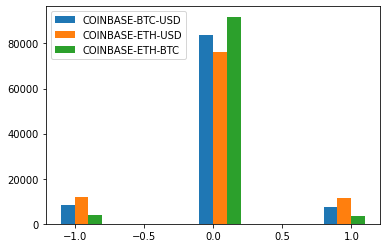

In [16]:
# Classes are imbalanced, need resampling to equalize them.
plt.hist(books[0]['signal1']-0.1, bins=20, label='COINBASE-BTC-USD')
plt.hist(books[1]['signal1']+0.0, bins=20, label='COINBASE-ETH-USD')
plt.hist(books[2]['signal1']+0.1, bins=20, label='COINBASE-ETH-BTC')
plt.legend()

# Resampling

In [17]:
targets = pd.concat([df['signal1'].rename(f'target{i}') for i, df in enumerate(books)], axis=1)
targets

,target0,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12,target13,target14,target15,target16,target17
ts,,,,,,,,,,,,,,,,,,
2022-03-05 20:16:22.300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-05 20:16:22.400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-05 20:16:22.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-05 20:16:22.600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-05 20:16:22.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-05 23:01:44.000,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-1.0,1.0,1.0,1.0
2022-03-05 23:01:44.100,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2022-03-05 23:01:44.200,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [18]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = prepare(scaler, config['model']['depth'], 18, config['model']['window_size'])

In [19]:
# dump scaler into file
scaler_path = os.path.join(model_dir, 'scaler.h5')
joblib.dump(scaler, scaler_path)

['_output/models/20220306_221216/scaler.h5']

# Model

In [23]:
def create_shared_layers(layers):

    def shared_layers(x):
        for layer in layers:
            x = layer(x)
        return x

    return shared_layers

def build_model(window_size, n_feeds, depth):
    
    inputs = Input(shape=(window_size, n_feeds, depth * 4, 1))
    
    # conv across price+volume
    x = Conv3D(16, kernel_size=(1, 1, 2), strides=(1, 1, 2), activation='relu')(inputs)
    x = Conv3D(16, kernel_size=(4, 1, 1), activation='relu', padding='same')(x)
    x = Conv3D(16, kernel_size=(4, 1, 1), activation='relu', padding='same')(x)

    # conv across bid+ask
    x = Conv3D(16, kernel_size=(1, 1, 2), strides=(1, 1, 2), activation='relu')(x)
    x = Conv3D(16, kernel_size=(4, 1, 1), activation='relu', padding='same')(x)
    x = Conv3D(16, kernel_size=(4, 1, 1), activation='relu', padding='same')(x)

    # conv across price levels
    x = Conv3D(16, kernel_size=(1, 1, depth), activation='relu')(x)
    x = Conv3D(16, kernel_size=(4, 1, 1), activation='relu', padding='same')(x)
    x = Conv3D(16, kernel_size=(4, 1, 1), activation='relu', padding='same')(x)

    # inception module
    y1 = Conv3D(32, kernel_size=(1, 1, 1), activation='relu', padding='same')(x)
    y1 = Conv3D(32, kernel_size=(3, 1, 1), activation='relu', padding='same')(y1)

    y2 = Conv3D(32, kernel_size=(1, 1, 1), activation='relu', padding='same')(x)
    y2 = Conv3D(32, kernel_size=(5, 1, 1), activation='relu', padding='same')(y2)

    y3 = MaxPooling3D(pool_size=(3, 1, 1), strides=(1, 1, 1), padding='same')(x)
    y3 = Conv3D(32, kernel_size=(1, 1, 1), activation='relu', padding='same')(y3)

    x = concatenate([y1, y2, y3])

    n_features = 4
    
    # conv across assets
    x = Conv3D(n_features * n_feeds / 3, kernel_size=(1, 3, 1), strides=(1, 3, 1), activation='relu')(x)
    x = Conv3D(n_features * n_feeds / 3, kernel_size=(4, 1, 1), activation='relu', padding='same')(x)
    x = Conv3D(n_features * n_feeds / 3, kernel_size=(4, 1, 1), activation='relu', padding='same')(x)

    # conv across exchanges
    x = Conv3D(n_features * n_feeds, kernel_size=(1, 4, 1), strides=(1, 4, 1), activation='relu')(x)
    x = Conv3D(n_features * n_feeds, kernel_size=(4, 1, 1), activation='relu', padding='same')(x)
    x = Conv3D(n_features * n_feeds, kernel_size=(4, 1, 1), activation='relu', padding='same')(x)

    # unstack
    x = Reshape((window_size, n_feeds, -1))(x)
    unstacked = Lambda(lambda x: tf.unstack(x, axis=2))(x)
    
    # LSTM
    layers = [
        LSTM(64),
        BatchNormalization(),
        Dropout(0.8),
    ]

    shared_layers = create_shared_layers(layers)
    outputs = [shared_layers(x) for x in unstacked]
    
    # fully-connected
    layer = Dense(3, activation='softmax')
    outputs = [layer(x) for x in outputs]
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [24]:
# build and train model

model = build_model(window_size=config['model']['window_size'], n_feeds=18, depth=config['model']['depth'] + 1)
cp_callback = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_weights_only=True, save_best_only=True)

In [25]:
model.summary(line_length=160)

Model: "model_1"
________________________________________________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape                        Param #            Connected to                                         
input_2 (InputLayer)                                [(None, 20, 18, 8, 1)]              0                                                                       
________________________________________________________________________________________________________________________________________________________________
conv3d_20 (Conv3D)                                  (None, 20, 18, 4, 16)               48                 input_2[0][0]                                        
________________________________________________________________________________________________________________________________________________________________
conv3d_21 (Conv3D

In [ ]:
history = model.fit(X_train, tf.unstack(y_train, axis=1),
                    epochs=config['training']['n_epochs'],
                    batch_size=config['training']['batch_size'],
                    validation_split=0.15, callbacks=[cp_callback],
                    verbose=2)

In [28]:
# save history
history_path = os.path.join(model_dir, 'history.csv')
history_df = pd.DataFrame(history.history)
history_df.to_csv(history_path, index=False)

In [31]:
pd.set_option('max_columns', 1000)

In [33]:
# load the best model
model.load_weights(model_path)

In [41]:
result

[9.042155265808105,
 0.8245424628257751,
 1.0146112442016602,
 0.30857589840888977,
 0.31706422567367554,
 0.9759923219680786,
 0.2893058955669403,
 0.34546175599098206,
 0.21086400747299194,
 0.22859202325344086,
 0.8885920643806458,
 0.5391098260879517,
 0.20242127776145935,
 0.952710747718811,
 0.37637531757354736,
 0.3477916717529297,
 0.4022066295146942,
 0.5289804339408875,
 0.28894558548927307,
 0.6797293424606323,
 0.6760625243186951,
 0.928869366645813,
 0.8873124122619629,
 0.5828303694725037,
 0.9295371770858765,
 0.9396554827690125,
 0.9324479103088379,
 0.9614546298980713,
 0.6254709362983704,
 0.7834704518318176,
 0.9745466709136963,
 0.5526770353317261,
 0.8828895688056946,
 0.9541336297988892,
 0.8952760100364685,
 0.8169503808021545,
 0.9667090773582458]

In [45]:
result = model.evaluate(X_test, tf.unstack(y_test, axis=1), verbose=0)
result

[21.10434341430664,
 2.1251134872436523,
 3.39290714263916,
 0.5461146831512451,
 0.6093209981918335,
 1.5584526062011719,
 0.6262316703796387,
 0.32036080956459045,
 0.2673851251602173,
 0.7569276690483093,
 1.8777180910110474,
 1.8920633792877197,
 0.4025658071041107,
 1.1881705522537231,
 0.6772088408470154,
 1.9142670631408691,
 0.8220734596252441,
 1.5216935873031616,
 0.6057612895965576,
 0.4237689673900604,
 0.36827781796455383,
 0.9185020923614502,
 0.7826722264289856,
 0.4262385964393616,
 0.8827176094055176,
 0.9615947008132935,
 0.9408295750617981,
 0.8839776515960693,
 0.35028475522994995,
 0.42210572957992554,
 0.9617458581924438,
 0.47049039602279663,
 0.7731465101242065,
 0.8104934096336365,
 0.8715790510177612,
 0.629202127456665,
 0.9438032507896423]

In [37]:
result = model.evaluate(X_train, tf.unstack(y_train, axis=1), verbose=0)
result

[9.042155265808105,
 0.8245424628257751,
 1.0146112442016602,
 0.30857589840888977,
 0.31706422567367554,
 0.9759923219680786,
 0.2893058955669403,
 0.34546175599098206,
 0.21086400747299194,
 0.22859202325344086,
 0.8885920643806458,
 0.5391098260879517,
 0.20242127776145935,
 0.952710747718811,
 0.37637531757354736,
 0.3477916717529297,
 0.4022066295146942,
 0.5289804339408875,
 0.28894558548927307,
 0.6797293424606323,
 0.6760625243186951,
 0.928869366645813,
 0.8873124122619629,
 0.5828303694725037,
 0.9295371770858765,
 0.9396554827690125,
 0.9324479103088379,
 0.9614546298980713,
 0.6254709362983704,
 0.7834704518318176,
 0.9745466709136963,
 0.5526770353317261,
 0.8828895688056946,
 0.9541336297988892,
 0.8952760100364685,
 0.8169503808021545,
 0.9667090773582458]

In [24]:
# training performance

loss, accuracy = model.evaluate(X_train, y_train, verbose=0)

y_pred_num = np.argmax(model.predict(X1_train), axis=1)
y_test_num = np.argmax(y_train, axis=1)

metrics = get_metrics(y_test_num, y_pred_num)

output_training = (
    f"training:\n\n"
    f"{'loss':20}{loss:7.4f}\n"
    f"{'accuracy':20}{accuracy:7.4f}\n\n"
    f"{metrics}"
)


In [25]:
# testing performance

loss, accuracy = model.evaluate(X1_test, y_test, verbose=0)

y_pred_num = np.argmax(model.predict(X1_test), axis=1)
y_test_num = np.argmax(y_test, axis=1)

metrics = get_metrics(y_test_num, y_pred_num)

output_testing = (
    f"testing:\n\n"
    f"{'loss':20}{loss:7.4f}\n"
    f"{'accuracy':20}{accuracy:7.4f}\n\n"
    f"{metrics}"
)


In [26]:
output = f"# {MODEL_TAG}\n\n"
output += '\n'.join([x+y for x, y in zip([x.ljust(48) for x in output_training.split('\n')], [x.ljust(48) for x in output_testing.split('\n')])])
print(output)

# Multi-model basic

training:                                       testing:                                        
                                                                                                
loss                 0.4823                     loss                 2.6034                     
accuracy             0.7982                     accuracy             0.5308                     
                                                                                                
r2                     0.65                     r2                    -0.89                     
precision            0.7854  0.6974  0.9748     precision            0.2629  0.7867  0.5856     
recall               0.9618  0.7489  0.6838     recall               0.6977  0.5152  0.4136     
fscore               0.8647  0.7222  0.8038     fscore               0.3819  0.6226  0.4848     
support                8331    8331    8331     support                2193    8855    1944     
         

In [406]:
f = open(metrics_path, 'w')
f.write(output)
f.close()
print(f"Metrics written to {metrics_path}.")

yaml.dump(config, open(config_path, 'w'))
print(f"Config copied to {config_path}.")

Metrics written to _output/models/20220220_012415/metrics.txt.
Config copied to _output/models/20220220_012415/config.yml.


In [408]:
print_models()

20220219_215213
Inception + testing set without look-ahead bias + signal1

loss                 0.5732
accuracy             0.8898

r2                    -2.82
precision            0.0231  0.9715  0.0307
recall               0.0605  0.9153  0.0923
fscore               0.0334  0.9426  0.0461
support                1867  135571    2405

confusion matrix    
    113    1629     125
   4605  124091    6875
    172    2011     222


20220220_003546
# Inception + testing set without look-ahead bias + signal2 + depth=1

training:                                       testing:                                        
                                                                                                
loss                 0.9319                     loss                 1.0493                     
accuracy             0.5403                     accuracy             0.4709                     
                                                                                             

# Backtesting

The goal is for the model to perform well out-of-sample (=for different time period), but as a sanity check, we first want to ensure that it performs well in-sample.

In [240]:
idxnum = range(100, len(df))

# prepare model
X1 = prepare(df, idxnum, config['model']['depth'], config['model']['window_size'])

# rescale
n_samples = X1.shape[0]
X1[:] = scaler.transform(X1[:, :, :, 0].reshape((n_samples, -1))).reshape((n_samples, config['model']['window_size'], config['model']['depth'] * 4, 1))

# encode labels
y = df[config['model']['label']].iloc[idxnum].to_numpy()
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(y.reshape(-1, 1))

X1.shape, y.shape


((699100, 20, 40, 1), (699100, 3))

In [241]:
# predict labels
ret_pred = model.predict(X1)
strategy = np.argmax(ret_pred, axis=1) - 1.

# calculating strategy
df.loc[df.index[idxnum], ['g-', 'g0', 'g+']] = ret_pred
df.loc[df.index[idxnum], 'signal_pred'] = strategy.reshape(-1)

df_strategy = df[~df.isna().any(axis=1)]
df_strategy.shape

(699100, 53)

<AxesSubplot:xlabel='timestamp'>

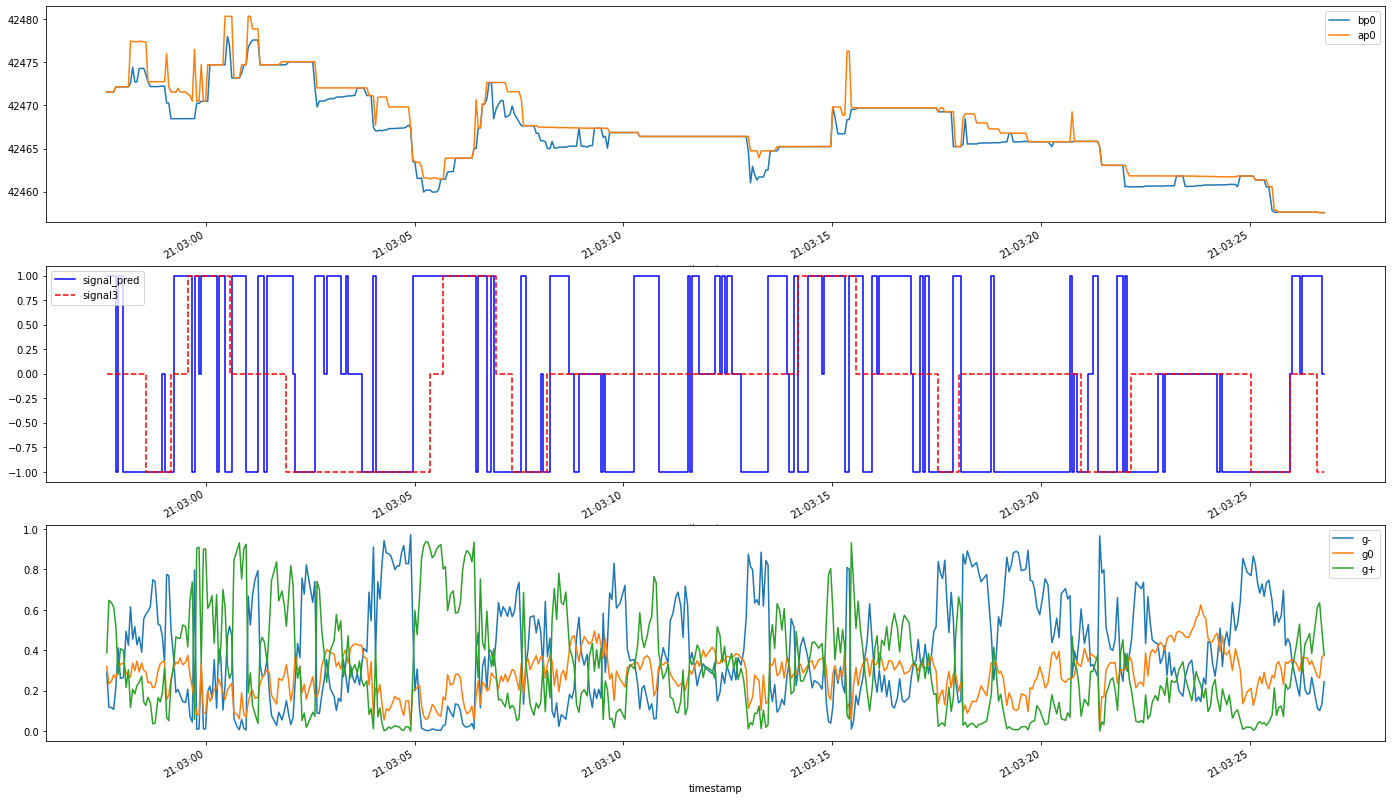

In [412]:
fig, ax = plt.subplots(nrows=3, figsize=(24, 15))

# offset, step = 690100, 500
offset, step = 3000, 500

df_strategy[offset:offset+step][['bp0', 'ap0']].plot(ax=ax[0])
df_strategy[offset:offset+step][['signal_pred']].plot(ax=ax[1], drawstyle="steps", c='b')
df_strategy[offset:offset+step][[config['model']['label']]].plot(ax=ax[1], drawstyle="steps", c='r', linestyle='dashed')
df_strategy[offset:offset+step][['g-', 'g0', 'g+']].plot(ax=ax[2])